In [1]:
%cd /home/yizi/side_info_decoding/side_info_decoding/lfads/

/home/yizi/side_info_decoding/side_info_decoding/lfads


In [2]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters

from side_info_decoding.utils import set_seed, load_data_from_pids

seed = 666
set_seed(seed)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [4]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
]

In [5]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="po",
    behavior="wheel_velocity",
    data_type="all_ks",
    n_t_bins = 50,
    t_before = .1,
    t_after = .4,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.
found 163 Kilosort units in region po


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 2433.75it/s]


In [6]:
pid = pids[0]
X, Y = np.moveaxis(X_dict[pid],1,-1), Y_dict[pid]
norm_Y = normalize(Y)
n_trials, n_t_bins, n_units = X.shape
print(X.shape)
print(Y.shape)

(367, 50, 156)
(367, 50)


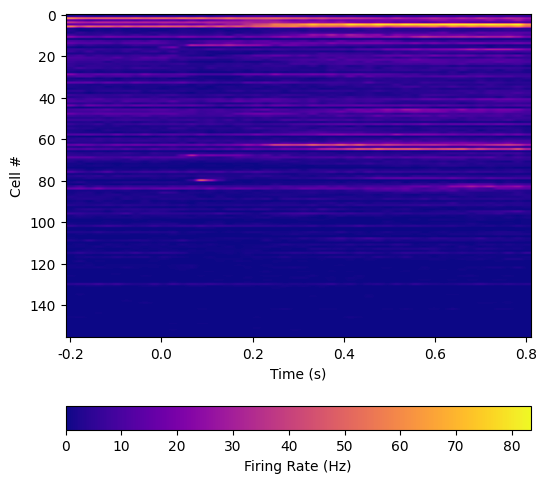

In [7]:
plt.figure(figsize = (6,6))
plt.imshow(X.mean(0).T/0.01, aspect="auto", cmap=plt.cm.plasma)
plt.xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-0.2, 0.8, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)');

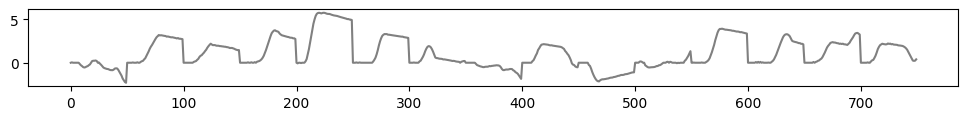

In [8]:
plt.figure(figsize=(12,1))
plt.plot(Y[10:10+15].flatten(), c="gray");

#### LFADS

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

In [10]:
all_data = torch.Tensor(X).to(device)
train_data = torch.Tensor(X_train).to(device)
valid_data = torch.Tensor(X_test).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

In [11]:
hyperparams = {'betas': (0.9, 0.99),
 'c_encoder_dim': 80,
 'clip_val': 5.0,
 'controller_dim': 80,
 'dataset_name': 'chaotic_rnn',
 'epsilon': 0.1,
 'factors_dim': 40,
 'g0_encoder_dim': 100,
 'g0_prior_kappa': 1e-2,
 'g_dim': 100,
 'keep_prob': 0.95,
 'kl_weight_schedule_dur': 0.8,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 10000, 
 'l2_weight_schedule_dur': 0.8,
 'l2_weight_schedule_start': 0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'run_name': 'demo',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 4,
 'u_prior_kappa': 0.1}

In [12]:
model = LFADS_Net(inputs_dim = n_units, T = n_t_bins, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 7474


In [13]:
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=32, use_tensorboard=False,
          train_truth=None, valid_truth=None)

Beginning training...
Epoch:    1, Step:    11, training loss: 172167.717, validation loss: 26058.422
Epoch:    2, Step:    22, training loss: 26227.013, validation loss: 9719.535
Epoch:    3, Step:    33, training loss: 16737.919, validation loss: 7207.739
Epoch:    4, Step:    44, training loss: 11970.096, validation loss: 5375.578
Epoch:    5, Step:    55, training loss: 9432.708, validation loss: 4474.546
Epoch:    6, Step:    66, training loss: 7382.396, validation loss: 3986.527
Epoch:    7, Step:    77, training loss: 5620.446, validation loss: 3352.068
Epoch:    8, Step:    88, training loss: 4547.350, validation loss: 2295.343
Epoch:    9, Step:    99, training loss: 3610.391, validation loss: 2465.619
Epoch:   10, Step:   110, training loss: 3056.256, validation loss: 1948.789
Epoch:   11, Step:   121, training loss: 2571.163, validation loss: 1807.103
Epoch:   12, Step:   132, training loss: 2160.895, validation loss: 1659.832
Epoch:   13, Step:   143, training loss: 1900.41

In [14]:
model.load_checkpoint('best')

In [15]:
with torch.no_grad():
    inferred_rates = np.array([model.reconstruct(all_data[i][None,:]) for i in range(n_trials)])

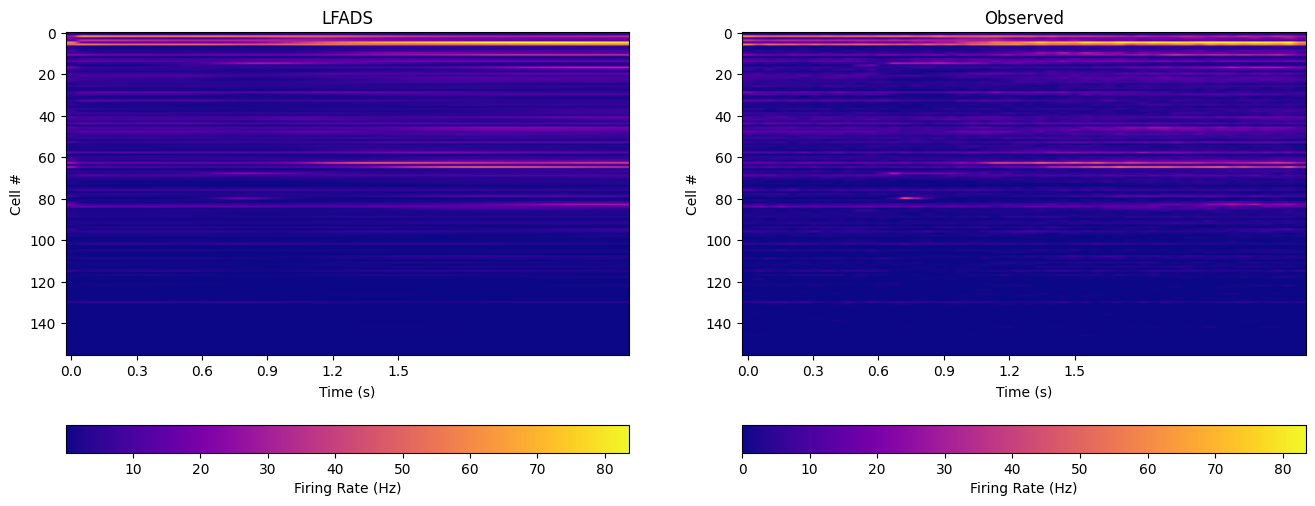

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(inferred_rates.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(0, 1.5, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('LFADS')

im2 = ax2.imshow(all_data.cpu().mean(0).T/0.01, aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(0, 1.5, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Firing Rate (Hz)')
ax2.set_title('Observed');

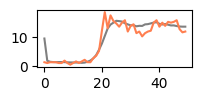

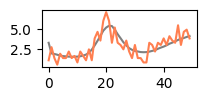

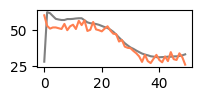

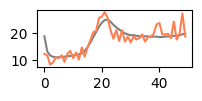

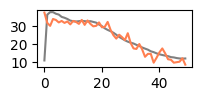

In [17]:
for unit_idx in np.arange(5):
    plt.figure(figsize=(2,.75))
    plt.plot(inferred_rates[:,:,unit_idx].mean(0), c="gray", label="LFADS")
    plt.plot(all_data.cpu()[:,:,unit_idx].mean(0)/0.01, c="coral", label="observed")
    plt.show()

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
penalty = [0.001, 0.01, 1, 100, 1000, 10000]

obs_lst, pred_lst, r2_lst, corr_lst = [], [], [], []
for fold_idx, (train, test) in enumerate(kf.split(inferred_rates)):
    train_X, test_X = inferred_rates[train], inferred_rates[test]
    train_Y, test_Y = norm_Y[train], norm_Y[test]
    train_X = train_X.reshape((-1, n_units))
    test_X = test_X.reshape((-1, n_units))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(len(test), n_t_bins)
    pred_Y = pred_Y.reshape(len(test), n_t_bins)
    obs_lst.append(test_Y)
    pred_lst.append(pred_Y)
    r2_lst.append(r2_score(test_Y.flatten(), pred_Y.flatten()))
    corr_lst.append(pearsonr(test_Y.flatten(), pred_Y.flatten())[0])

obs_lst = np.vstack(obs_lst)     
pred_lst = np.vstack(pred_lst)    
print(f"5-fold CV r2: {np.mean(r2_lst)} corr: {np.mean(corr_lst)}")

5-fold CV r2: 0.07918491654924797 corr: 0.30422465460391324


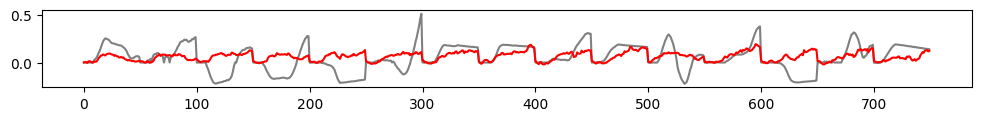

In [19]:
plt.figure(figsize=(12,1))
plt.plot(obs_lst[10:10+15].flatten(), c="gray")
plt.plot(pred_lst[10:10+15].flatten(), c="r");